Здесь будем фигачить признаки для деревьев, поэтому скоррелированные не выкидываем

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc

In [2]:
from scipy import stats

In [3]:
sns.set_context('talk')

In [4]:
pd.set_option('display.max_columns', 500)

In [5]:
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

# Read the data

In [6]:
test = pd.read_csv('csv/ech_test.csv', sep=';', index_col='id')
train = pd.read_csv('csv/ech_apprentissage.csv', sep=';', index_col='id')

/home/alexey/.environments/ml/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Graphs

In [7]:
train.columns

Index(['annee_naissance', 'annee_permis', 'marque', 'puis_fiscale', 'anc_veh',
       'codepostal', 'energie_veh', 'kmage_annuel', 'crm', 'profession',
       'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9',
       'var10', 'var11', 'var12', 'var13', 'var14', 'var15', 'var16', 'var17',
       'var18', 'var19', 'var20', 'var21', 'var22', 'prime_tot_ttc'],
      dtype='object')

Заменим NR на NaN

In [8]:
train.replace('NR', np.NaN, inplace=True)
test.replace('NR', np.NaN, inplace=True)

Заменим ARMEE в codepostal на -1

In [9]:
train.loc[train.codepostal == 'ARMEE', 'codepostal'] = '-1'

In [10]:
train.loc[train.codepostal == '-1', 'codepostal']

id
46294    -1
46295    -1
46296    -1
Name: codepostal, dtype: object

Переведём codepostal в числа

In [11]:
train.codepostal = pd.to_numeric(train.codepostal)

In [12]:
test.codepostal.dtype

dtype('int64')

С тестом всё норм

Разделим codepostal на часть, относящуюся к региону, и на остальное. Учтём всякие крайние случаи типа заморских территорий.

In [13]:
def split_postcode(df):
    df['department'] = df['codepostal'] // 1000
    df['subreg'] = df['codepostal'] % 1000
    overseas = (df['department'] == 98) | (df['department'] == 97)
    df.ix[overseas, 'department'] = df['codepostal'] // 100
    df.ix[overseas, 'subreg'] = df['codepostal'] % 100
    return df.drop('codepostal', axis=1)

In [14]:
train = split_postcode(train)

In [15]:
test = split_postcode(test)

Посмотрим на категориальные

In [16]:
categorical = []
for col in train.columns:
    if train[col].dtype not in ['int64', 'float64']:
        print(col, train[col].dtype)
        categorical.append(col)

marque object
energie_veh object
profession object
var6 object
var7 object
var8 object
var14 object
var16 object


In [17]:
for col in categorical:
    print(col, '\n', set(train[col]), '\n\n')

marque 
 {nan, 'OPEL', 'INTERNATIONAL', 'STRAUBENHARDT', 'ASIA', 'HUMMER', 'SUBARU', 'MORRIS', 'PLYMOUTH', 'ENGIN TRAVAUX PUBLIC', 'CADILLAC', 'VOLVO', 'MAZDA', 'MCC', 'SAVIEM', 'YAMAHA', 'LAND-ROVER', 'PANHARD', 'ALFA ROMEO', 'UNIMOG', 'DODGE', 'ACMA', 'SOVRA', 'TALBOT', 'RELIANT', 'SEAT', 'AMPHICAR', 'ENGIN LOISIRS', 'LAFER', 'RAMBLER', 'DACIA', 'DELAHAYE', 'SIMCA', 'SSANGYONG', 'AUTOBIANCHI', 'GMC', 'AMC', 'ISUZU', 'LEXUS', 'SKODA', 'BMW', 'LADA', 'TVR', 'COURNIL', 'RAYTON FISSORE', 'FSO', 'NISSAN', 'DAIHATSU', 'SANTANA', 'WILLYS', 'FIAT', 'FERRARI', 'HONDA', 'DATSUN', 'MAHINDRA', 'BERTONE', 'FORD', 'CATERHAM', 'TEILHOL', 'MASERATI', 'CARBODIES', 'LDV', 'MERCEDES', 'OLDSMOBILE', 'SATURN', 'HANOMAG', 'VEH SPECIAL', 'GRANDIN', 'LANCIA', 'MINI', 'AUVERLAND', 'PORSCHE', 'EBS', 'PONCIN', 'UMM', 'BEDFORD', 'ASTON MARTIN', 'RENAULT', 'MG', 'AUTO-UNION', 'MOKE', 'EAGLE', 'SAAB', 'PONTIAC', 'LINCOLN', 'LAMBORGHINI', 'AUTOLAND', 'TATA', 'AUDI', 'NSU', 'CHENARD ET WALKER', 'CHEYENNE', 'INFINIT

Переведём в численные те признаки, которые посчитались за категориальные, потому что в них был NR (var7, var16). 

In [18]:
train.var7 = pd.to_numeric(train.var7)
train.var16 = pd.to_numeric(train.var16)

In [19]:
test.var7 = pd.to_numeric(test.var7)
test.var16 = pd.to_numeric(test.var16)

Опять посмотрим, но сразу с тестом

In [20]:
categorical = []
bigX = pd.concat([train.drop('prime_tot_ttc', axis=1), test])
for col in bigX.columns:
    if bigX[col].dtype not in ['int64', 'float64']:
        categorical.append(col)
for col in categorical:
    s = set(bigX[col])
    print(col, len(s), '\n', s, '\n\n')        

marque 157 
 {nan, 'OPEL', 'INTERNATIONAL', 'STRAUBENHARDT', 'ASIA', 'HUMMER', 'SUBARU', 'MORRIS', 'PLYMOUTH', 'ENGIN TRAVAUX PUBLIC', 'CADILLAC', 'VOLVO', 'MAZDA', 'MCC', 'SAVIEM', 'YAMAHA', 'LAND-ROVER', 'PANHARD', 'ALFA ROMEO', 'UNIMOG', 'DODGE', 'ACMA', 'SOVRA', 'TALBOT', 'RELIANT', 'SEAT', 'AMPHICAR', 'ENGIN LOISIRS', 'LAFER', 'RAMBLER', 'DACIA', 'DELAHAYE', 'SIMCA', 'SSANGYONG', 'AUTOBIANCHI', 'GMC', 'AMC', 'ISUZU', 'LEXUS', 'SKODA', 'BMW', 'LADA', 'TVR', 'COURNIL', 'RAYTON FISSORE', 'FSO', 'NISSAN', 'DAIHATSU', 'SANTANA', 'WILLYS', 'FIAT', 'FERRARI', 'HONDA', 'DATSUN', 'MAHINDRA', 'BERTONE', 'FORD', 'CATERHAM', 'TEILHOL', 'MASERATI', 'CARBODIES', 'LDV', 'MERCEDES', 'OLDSMOBILE', 'SATURN', 'HANOMAG', 'VEH SPECIAL', 'GRANDIN', 'LANCIA', 'MINI', 'AUVERLAND', 'PORSCHE', 'EBS', 'PONCIN', 'UMM', 'BEDFORD', 'ASTON MARTIN', 'RENAULT', 'MG', 'AUTO-UNION', 'SOVAM', 'MOKE', 'EAGLE', 'SAAB', 'PONTIAC', 'LINCOLN', 'LAMBORGHINI', 'AUTOLAND', 'TATA', 'AUDI', 'NSU', 'CHENARD ET WALKER', 'CHEYEN

В категорию маломощных категориалов выделяются var14, var6, energie_veh.

Средние var8, proffession

Большие marque

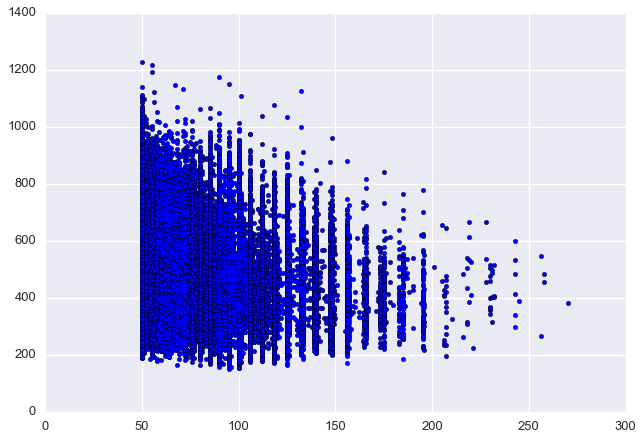

In [21]:
plt.scatter(train.crm, train.prime_tot_ttc / train.crm * 100)
plt.show()

In [22]:
train.drop('crm', axis=1).drop_duplicates().shape

(299987, 33)

In [23]:
train.drop_duplicates().shape

(299987, 34)

In [24]:
normed_train = train.drop('prime_tot_ttc', axis=1)
normed_train['target'] = np.log(train.prime_tot_ttc / train.crm * 100)

In [25]:
normed_train.drop('crm', axis=1).drop_duplicates().shape

(299987, 33)

In [26]:
normed_train.drop_duplicates().shape

(299987, 34)

Есть только полные дубли. Объектов с разным CRM, но с одинаковым таргетом нет

Если считать, что prime_tot_ttc -- реально предъявляемая стоимость страховки, то из неё нужно вычесть налоги, чтобы получить то, что компания берёт себе

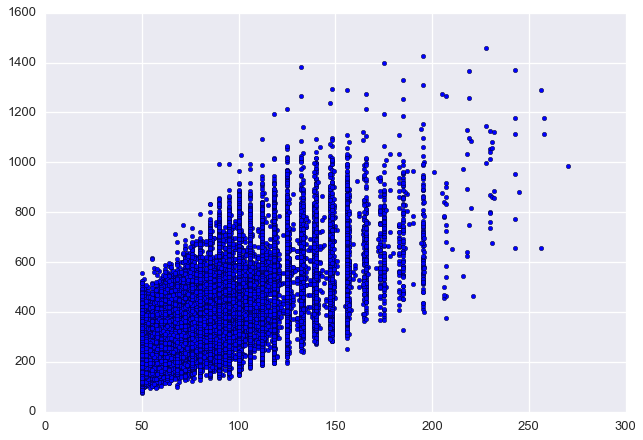

In [27]:
plt.scatter(train.crm, train.prime_tot_ttc * (1 - train.puis_fiscale / 100))
plt.show()

Теперь это поделим на crm

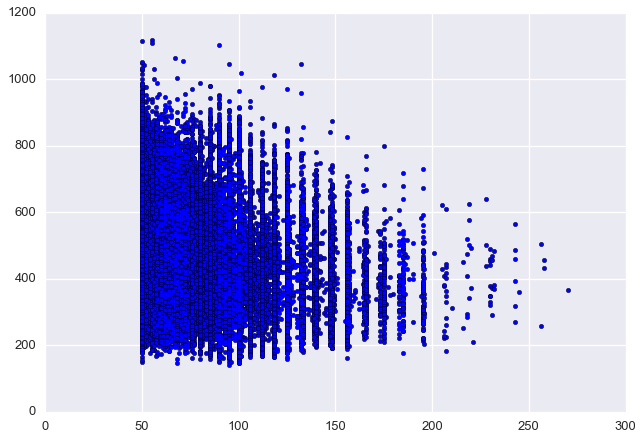

In [28]:
plt.scatter(train.crm, train.prime_tot_ttc * (1 - train.puis_fiscale / 100) / train.crm * 100)
plt.show()

Если считать, что больше от налогов и crm ничего не зависит, то выкинем их и изменим таргет

In [29]:
normed_train = train.drop(['prime_tot_ttc', 'crm', 'puis_fiscale'], axis=1)
normed_train['target'] = np.log(train.prime_tot_ttc * (1 - train.puis_fiscale / 100) / train.crm * 100)

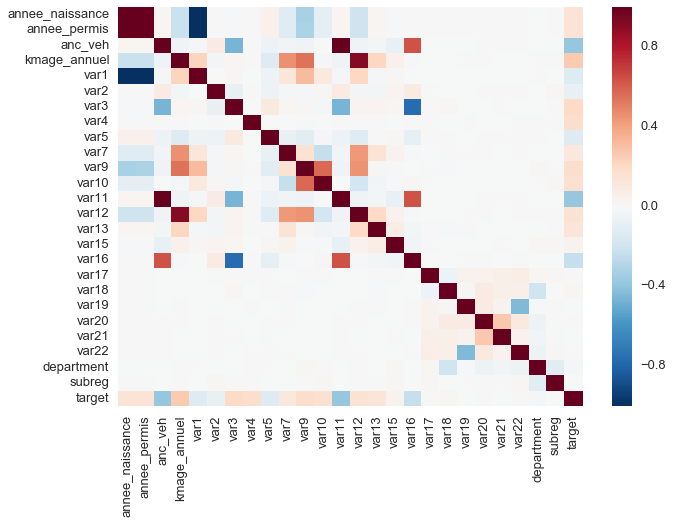

In [30]:
sns.heatmap(normed_train.corr())

In [31]:
normed_train.corr().target.sort_values()

anc_veh           -0.387538
var11             -0.386783
var16             -0.239927
var1              -0.135220
var5              -0.129734
var2              -0.076090
department        -0.021942
var19             -0.004077
subreg            -0.002197
var21             -0.000272
var20              0.001517
var17              0.004027
var22              0.004193
var18              0.011738
var15              0.032677
var7               0.106910
var13              0.129718
annee_naissance    0.134478
annee_permis       0.135220
var12              0.146322
var10              0.156576
var4               0.173806
var9               0.177180
var3               0.197127
kmage_annuel       0.262338
target             1.000000
Name: target, dtype: float64

Очень сильное предположение. Пусть поправки, вносимые каждой переменной, независимы. То есть таргет есть сумма функций от каждой переменной в отдельности. Каждая такая функция есть неглубокое решающее дерево

In [32]:
validation_index = (train.department == 1) | (train.department > 90)
train_index = ~validation_index

In [33]:
target = normed_train.target

In [34]:
dummy_train = pd.get_dummies(normed_train.drop('target', axis=1))

In [35]:
dummy_train.shape

(300000, 237)

In [36]:
dummy_train.fillna(-9999, inplace=True)

In [37]:
subtrain, validation = dummy_train[train_index], dummy_train[validation_index]
x_subtrain = np.array(subtrain)
x_validation = np.array(validation)

targetsubtrain, targetvalidation = target[train_index], target[validation_index]
t_subtrain = np.array(targetsubtrain).flatten()
t_validation = np.array(targetvalidation).flatten()

In [38]:
y_validation = np.array(train.prime_tot_ttc[validation_index]).flatten()

In [39]:
del subtrain
del validation

In [40]:
gc.collect()

13213

In [41]:
from sklearn.ensemble import ExtraTreesRegressor

In [42]:
%%time
est = ExtraTreesRegressor(n_estimators=10, max_features=None, 
                          max_depth=None, n_jobs=-1, random_state=42).fit(X=x_subtrain, y=t_subtrain)

CPU times: user 2min 54s, sys: 316 ms, total: 2min 54s
Wall time: 51.2 s


In [43]:
def mape(y_true, y_pred):
    y_pred = y_pred.reshape(y_true.shape)
    return -np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [44]:
def restore_y(pred, crm, fiscale):
    return np.exp(pred) / (1 - fiscale / 100) * crm / 100

In [45]:
target_pred = est.predict(x_validation)
y_pred = restore_y(target_pred, np.array(train.crm[validation_index]), np.array(train.puis_fiscale[validation_index]))
mape(y_validation, y_pred)

-10.757877774681447

Норм, не треш делаем, значит

In [46]:
%%time
est = ExtraTreesRegressor(n_estimators=40, max_features=None, 
                          max_depth=None, n_jobs=-1, random_state=42).fit(X=x_subtrain, y=t_subtrain)

CPU times: user 12min 23s, sys: 1.73 s, total: 12min 25s
Wall time: 3min 10s


In [47]:
target_pred = est.predict(x_validation)
y_pred = restore_y(target_pred, np.array(train.crm[validation_index]), np.array(train.puis_fiscale[validation_index]))
mape(y_validation, y_pred)

-10.314196207086255

Попробуем зафиксировать некоторые переменные и посмотреть на остальное

In [48]:
normed_train.columns

Index(['annee_naissance', 'annee_permis', 'marque', 'anc_veh', 'energie_veh',
       'kmage_annuel', 'profession', 'var1', 'var2', 'var3', 'var4', 'var5',
       'var6', 'var7', 'var8', 'var9', 'var10', 'var11', 'var12', 'var13',
       'var14', 'var15', 'var16', 'var17', 'var18', 'var19', 'var20', 'var21',
       'var22', 'department', 'subreg', 'target'],
      dtype='object')

In [78]:
normed_train.groupby(['marque', 'kmage_annuel']).size().sort_values(ascending=False)

marque      kmage_annuel
RENAULT     2983            2427
            3098            2243
            7183            1932
            7071            1912
            6260            1879
            2906            1785
PEUGEOT     6511            1687
RENAULT     6308            1603
            6324            1508
            7266            1337
PEUGEOT     6572            1314
            7141            1284
CITROEN     3074            1280
PEUGEOT     6542            1261
            2966            1245
RENAULT     7321            1228
CITROEN     6393            1209
PEUGEOT     6374            1185
RENAULT     6572            1177
            7563            1116
            6855            1102
            7402            1087
CITROEN     7211            1066
RENAULT     6526            1045
            6913            1044
PEUGEOT     6752            1043
RENAULT     6985            1019
            2810             948
PEUGEOT     7539             946
RENAULT     6496  

In [48]:
for col in normed_train.columns:
    if normed_train[col].dtype in ['int64', 'float64']:
        print(normed_train[col].nunique(), col, normed_train[col].dtype)

68 annee_naissance float64
69 annee_permis float64
44 anc_veh int64
1244 kmage_annuel int64
69 var1 float64
6 var2 int64
2 var3 int64
10 var4 int64
2 var5 int64
18 var7 float64
335 var9 int64
213 var10 int64
44 var11 int64
1244 var12 int64
4 var13 int64
10 var15 int64
6 var16 float64
6 var17 int64
46 var18 int64
29 var19 int64
2 var20 int64
2 var21 int64
25 var22 int64
97 department float64
863 subreg float64
250344 target float64


Так как у нас есть предположение о сумме функций от каждой переменной, давайте всё за one-hot-encod'им, и потом это скормим sgd с epsilon-tube

In [49]:
dummy_train = None
gc.collect()

158

In [56]:
dropped_normed_train = normed_train.drop(['target', 'subreg'], axis=1)

In [58]:
for col in dropped_normed_train.columns:
    if dropped_normed_train[col].dtype in ['float64']:
        dropped_normed_train[col] = np.int64(dropped_normed_train[col])

In [63]:
dropped_normed_train[train.department.isnull()].department

id
46316    -9223372036854775808
46317    -9223372036854775808
46318    -9223372036854775808
296254   -9223372036854775808
296255   -9223372036854775808
Name: department, dtype: int64

Норм разобрался с пропусками

Так, смысл такой. Сделать базовую обработку, перевести float в int. Записать это в файлы, не выбрасывая ни один признак.

При обучении (сначала перейти к нормальному лог-таргету, учтя налоги и КБМ, налоги и КБМ выбросить) сделать label encode для оставшихся категориальных, потом всё, вот прямо все признаки пропустить через one hot encoder в sparse матрицу. Это уже скормить линейным регрессорам. 

# Target label separation 

In [197]:
y_train = train['prime_tot_ttc']
train = train.drop('prime_tot_ttc', axis=1)

# Save to file

In [198]:
y_train.to_csv('preprocessed_csv/y_train_new.csv', sep=';')

In [199]:
train.to_csv('preprocessed_csv/train_new.csv', sep=';')

In [200]:
test.to_csv('preprocessed_csv/test_new.csv', sep=';')